# Project 5: mini machine learning project

Maaike de Jong 

Ironhack Amsterdam Data Analytics 2020

### Notebook 2: analysis


This project uses the data from project 2: Sustainability in Amsterdam

In this project I will use Machine Learning models to see to what extent green indicator variables can predict income and Amsterdam city district. My questions are:

Q1: How well do energy label scores and number of solar panels predict income? 
Q2: Can energy scores, solar panels and income predict the city district?

I used the following datasets:
From the [maps data portal](https://maps.amsterdam.nl/open_geodata/) of the Amsterdam city council:
- Solar panels (Zonnepanelen)
- Postcodes (PC6_VLAKKEN_BAG.csv)
- Neighbourhoods (GEBIED_BUURTEN.csv)
- City districts (GEBIED_STADSDELEN.csv)

From [Overheid.nl](overheid.nl):
- Energylabels in Amsterdam
- Income per Amsterdam area

All datasets can be found in [this google folder](https://drive.google.com/drive/folders/19VhvQbT89SLKaLnWsP20jhrTrqCvwMbd) 

This is the second part of two notebooks, part one deals with the data wrangling to combine variables from different datasets into the dataset used here for analysis.

In [3]:
# import packages

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

from scipy.stats import chi2_contingency

In [4]:
df = pd.read_csv('final_data_income.csv')
df.head()

,Buurtcode,energy_class_score,solar_panels,Stadsdeel_code,LNG,LAT,Stadsdeel,area,mean_income (x 1.000 euro)
0,A00a,4.222222,0.0,A,4.900171,52.375723,Centrum,A00,35.2
1,A00b,5.353846,0.0,A,4.896214,52.373797,Centrum,A00,35.2
2,A00c,3.531915,13.0,A,4.898577,52.372857,Centrum,A00,35.2
3,A00d,2.300000,0.0,A,4.893950,52.370864,Centrum,A00,35.2
4,A00e,4.956522,0.0,A,4.895578,52.369559,Centrum,A00,35.2


In [5]:
df = df.rename(columns = {'energy_class_score': 'energy_score', 'mean_income (x 1.000 euro)': 'income'})
df.head()

,Buurtcode,energy_score,solar_panels,Stadsdeel_code,LNG,LAT,Stadsdeel,area,income
0,A00a,4.222222,0.0,A,4.900171,52.375723,Centrum,A00,35.2
1,A00b,5.353846,0.0,A,4.896214,52.373797,Centrum,A00,35.2
2,A00c,3.531915,13.0,A,4.898577,52.372857,Centrum,A00,35.2
3,A00d,2.300000,0.0,A,4.893950,52.370864,Centrum,A00,35.2
4,A00e,4.956522,0.0,A,4.895578,52.369559,Centrum,A00,35.2


In [6]:
# inspect the data

df.dtypes

Buurtcode          object
energy_score      float64
solar_panels      float64
Stadsdeel_code     object
LNG               float64
LAT               float64
Stadsdeel          object
area               object
income            float64
dtype: object

In [7]:
df.shape

(418, 9)

In [8]:
# check missing values
df.isnull().sum()

# no missing values

Buurtcode         0
energy_score      0
solar_panels      0
Stadsdeel_code    0
LNG               0
LAT               0
Stadsdeel         0
area              0
income            0
dtype: int64

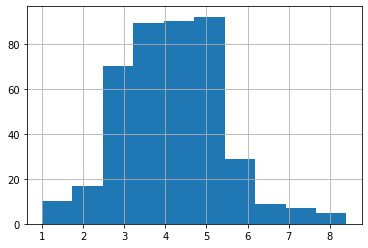

In [9]:
# inspect distribution of the variables

df['energy_score'].hist()

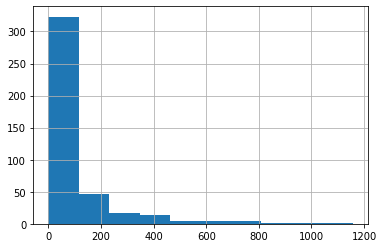

In [10]:
df['solar_panels'].hist()


In [11]:
df[df['solar_panels'] == 0].shape

# 154 of the 418 buurten have 0 solar panels. This might cause unbalance

(154, 9)

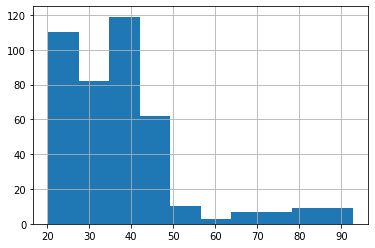

In [12]:
df['income'].hist()

In [13]:
# investigate correlations

df[['energy_score', 'solar_panels', 'income']].corr()

# no meaningful correlations

,energy_score,solar_panels,income
energy_score,1.000000,0.096768,-0.116092
solar_panels,0.096768,1.000000,-0.041705
income,-0.116092,-0.041705,1.000000


## Apply different types of supervised models

### First, linear regression with energy score and solar panels predicting income

In [14]:
# define predicting and predicted variables

y = df['income']
X = df[['energy_score', 'solar_panels']] 

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [16]:

LM = linear_model.LinearRegression()

In [17]:
LM.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [18]:
y_pred = LM.predict(X_test)
pd.DataFrame({'test':y_test, 'predicted':y_pred})

,test,predicted
387,22.3,37.325625
246,46.1,39.263890
323,32.9,40.749902
66,35.4,37.800972
205,38.8,35.793761
...,...,...
289,45.5,35.209145
398,25.0,36.043918
393,25.0,39.616586
283,26.6,36.051862


In [19]:
# calculate the r squared score between y_pred and y_train which indicates how well the estimated regression model fits the training data

y_pred = LM.predict(X_train)
r2_score(y_train, y_pred)

0.030009825048162297

In [20]:
# calculate the r squared score between y_pred and y_test

y_test_pred = LM.predict(X_test)
r2_score(y_test, y_test_pred)

-0.046515492254872504

In [21]:
# These score show that the model doesn't fit and the variables are likely unsuitable predictors of income
#Paolo: yes. These results could be anticipated already by looking at low correlations between these features
# and the target

### Second, try supervised learning classification models

Again, test whether energy score and solar panels can predict income, using the following models:
- Logistic Regression
- K-nearest neighbor

In [22]:
# make income into a categorical variable
# check range

df['income'].describe()


count    418.000000
mean      37.713158
std       14.472234
min       20.300000
25%       26.850000
50%       35.400000
75%       42.800000
max       92.700000
Name: income, dtype: float64

In [23]:
# divide income into quantile categories

df['income_cat'] = pd.cut(df['income'], bins=[20.0, 26.85, 35.4, 42.8, 92.7], labels=['low','medium-low','medium-high','high'])

In [24]:
df.head()

,Buurtcode,energy_score,solar_panels,Stadsdeel_code,LNG,LAT,Stadsdeel,area,income,income_cat
0,A00a,4.222222,0.0,A,4.900171,52.375723,Centrum,A00,35.2,medium-low
1,A00b,5.353846,0.0,A,4.896214,52.373797,Centrum,A00,35.2,medium-low
2,A00c,3.531915,13.0,A,4.898577,52.372857,Centrum,A00,35.2,medium-low
3,A00d,2.300000,0.0,A,4.893950,52.370864,Centrum,A00,35.2,medium-low
4,A00e,4.956522,0.0,A,4.895578,52.369559,Centrum,A00,35.2,medium-low


In [25]:
y = df['income_cat']
X = df[['energy_score', 'solar_panels']] 

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [27]:
# Initiate Logistic Regression model

logreg = LogisticRegression()

In [28]:
logreg.max_iter=1000
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [29]:
# Assign the fitted data to y_pred 

y_pred = logreg.predict(X_test)
pd.DataFrame({'test':y_test, 'predicted':y_pred})

,test,predicted
53,high,medium-high
299,high,medium-low
379,low,medium-low
128,medium-low,medium-high
1,medium-low,medium-high
...,...,...
279,medium-low,medium-low
61,high,medium-low
27,medium-high,medium-low
357,low,medium-low


In [30]:
# print confusion matrix:

confusion_matrix(y_test, y_pred)

array([[ 0,  0,  3, 18],
       [ 0,  0,  0, 28],
       [ 0,  1,  3, 15],
       [ 0,  0,  3, 13]], dtype=int64)

In [31]:
# print accuracy score
accuracy_score(y_test, y_pred)

# the score is still low but a lot better than with the linear regression

0.19047619047619047

In [32]:
# Now a K-nearest neighbors approach

In [33]:
KNN3 = KNeighborsClassifier(n_neighbors = 3)
KNN3.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [34]:
y_pred = KNN3.predict(X_test)

In [35]:
confusion_matrix(y_test, y_pred)

array([[10,  4,  4,  3],
       [10,  9,  6,  3],
       [ 5,  4,  5,  5],
       [ 6,  2,  3,  5]], dtype=int64)

In [36]:
accuracy_score(y_test, y_pred)
# this score is still not great, but better than logistic regression

0.34523809523809523

In [37]:
# same model with k = 5

KNN5 = KNeighborsClassifier(n_neighbors = 5)
KNN5.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [38]:
y_pred = KNN5.predict(X_test)

In [39]:
confusion_matrix(y_test, y_pred)

array([[ 8,  4,  7,  2],
       [ 8, 12,  6,  2],
       [ 3,  6,  6,  4],
       [ 5,  4,  3,  4]], dtype=int64)

In [40]:
accuracy_score(y_test, y_pred)

# this score is slightly lower than k=3, so not an improvement

0.35714285714285715

### A supervised clustering model predicting stadsdeel

Here I use the variables energy score, solar panels and income to predict stadsdeel

In [41]:
# First, with unscaled variables

y = df['Stadsdeel']
X = df[['energy_score', 'solar_panels', 'income']] 

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [43]:
logreg = LogisticRegression()

In [44]:
logreg.max_iter=10000
logreg.fit(X_train, y_train)

# had to increase the nr of iterations to 10000 to avoid a convergence warning

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [45]:
# Assign the fitted data to y_pred 

y_pred = logreg.predict(X_test)
pd.DataFrame({'test':y_test, 'predicted':y_pred})

,test,predicted
261,Zuid,Oost
118,West,West
411,Zuidoost,Zuidoost
154,Nieuw-West,Zuidoost
409,Zuidoost,Zuidoost
...,...,...
228,Zuid,Zuid
273,Oost,West
113,West,West
210,Zuid,Noord


In [46]:
# print accuracy score
accuracy_score(y_test, y_pred)

# The score is 0.38

0.40476190476190477

In [47]:
# Now with K-nearest neighbors

KNN3 = KNeighborsClassifier(n_neighbors = 3)
KNN3.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [48]:
y_pred = KNN3.predict(X_test)

In [49]:
accuracy_score(y_test, y_pred)
# this score is similar as logistic regression

0.40476190476190477

In [50]:
# same model with k = 5

KNN5 = KNeighborsClassifier(n_neighbors = 5)
KNN5.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [51]:
y_pred = KNN5.predict(X_test)

In [52]:
accuracy_score(y_test, y_pred)
# this score is similar, not an improvement

0.4523809523809524

In [53]:
# Now check whether it helps to scale the data

scaler = StandardScaler()

X_scaled = scaler.fit_transform(df[['energy_score', 'solar_panels', 'income']])
X_scaled = pd.DataFrame(X_scaled)

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20)

In [55]:
logreg = LogisticRegression()

In [56]:
logreg.max_iter=1000
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [57]:
# Assign the fitted data to y_pred 

y_pred = logreg.predict(X_test)
pd.DataFrame({'test':y_test, 'predicted':y_pred})

,test,predicted
270,Oost,West
56,Centrum,Centrum
185,Nieuw-West,West
151,Nieuw-West,Nieuw-West
273,Oost,West
...,...,...
14,Centrum,Zuid
364,Noord,Oost
181,Nieuw-West,West
276,Oost,Noord


In [58]:
# print accuracy score
accuracy_score(y_test, y_pred)

# similar accuracy score, not an improvement 

0.35714285714285715

## Unsupervised learning model

In [59]:
# Here I will use energy labels, solar panels and income data to create clusters
# and check to what extent these align with stadsdelen

# First, make two versions of the dataset: one with the untransformed relevant columns, one with transformed

ULdf = df[['energy_score', 'solar_panels', 'income']]

scaler = StandardScaler()
ULdf_scaled = scaler.fit_transform(ULdf)
ULdf_scaled = pd.DataFrame(ULdf_scaled)

In [60]:
# Data clustering with K-means

# unscaled data

kmeans = KMeans().fit(ULdf)
df['kmeans_labels'] = kmeans.labels_

In [61]:
# scaled data

kmeans2 = KMeans().fit(ULdf_scaled)
df['kmeans_scaled_labels'] = kmeans2.labels_

In [62]:
# Data clustering with DBSCAN

# unscaled data

dbscan = DBSCAN(eps=0.5).fit(ULdf)

df['dbscan_labels'] = dbscan.labels_

In [63]:
# scaled data

dbscan2 = DBSCAN(eps=0.5).fit(ULdf_scaled)

df['dbscan_scaled_labels'] = dbscan2.labels_

In [64]:
df.head()

,Buurtcode,energy_score,solar_panels,Stadsdeel_code,LNG,LAT,Stadsdeel,area,income,income_cat,kmeans_labels,kmeans_scaled_labels,dbscan_labels,dbscan_scaled_labels
0,A00a,4.222222,0.0,A,4.900171,52.375723,Centrum,A00,35.2,medium-low,1,3,-1,0
1,A00b,5.353846,0.0,A,4.896214,52.373797,Centrum,A00,35.2,medium-low,1,3,-1,0
2,A00c,3.531915,13.0,A,4.898577,52.372857,Centrum,A00,35.2,medium-low,1,1,-1,0
3,A00d,2.300000,0.0,A,4.893950,52.370864,Centrum,A00,35.2,medium-low,1,4,-1,0
4,A00e,4.956522,0.0,A,4.895578,52.369559,Centrum,A00,35.2,medium-low,1,3,-1,0


In [65]:
df['kmeans_labels'].value_counts()

1    249
6     56
4     47
0     23
7     16
3     13
2     10
5      4
Name: kmeans_labels, dtype: int64

In [66]:
df['kmeans_scaled_labels'].value_counts()

3    123
1    101
4     80
7     32
0     32
6     23
5     15
2     12
Name: kmeans_scaled_labels, dtype: int64

In [67]:
df['dbscan_labels'].value_counts()

-1    406
 1      7
 0      5
Name: dbscan_labels, dtype: int64

In [68]:
df['dbscan_scaled_labels'].value_counts()

 0    324
-1     82
 1      7
 2      5
Name: dbscan_scaled_labels, dtype: int64

In [69]:
# looking at these outcomes, I'm going to go with the kmeans analysis with the scaled data

df.dtypes

Buurtcode                 object
energy_score             float64
solar_panels             float64
Stadsdeel_code            object
LNG                      float64
LAT                      float64
Stadsdeel                 object
area                      object
income                   float64
income_cat              category
kmeans_labels              int32
kmeans_scaled_labels       int32
dbscan_labels              int64
dbscan_scaled_labels       int64
dtype: object

In [70]:
# perform a Chi-square test of independence to check whether there is a relationship between Stadsdelen and the kmeans clusters

# format the data

df_x2 = df[['Stadsdeel', 'kmeans_scaled_labels']]
df_x2.head()

,Stadsdeel,kmeans_scaled_labels
0,Centrum,3
1,Centrum,3
2,Centrum,1
3,Centrum,4
4,Centrum,3


In [71]:
# transform kmeans labels to str

df_x2['kmeans_scaled_labels'] = df['kmeans_scaled_labels'].apply(str)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [72]:
df_x2.dtypes

Stadsdeel               object
kmeans_scaled_labels    object
dtype: object

In [73]:
dfx2 = df_x2.groupby('Stadsdeel')['kmeans_scaled_labels'].value_counts().unstack().fillna(0)

In [74]:
dfx2

kmeans_scaled_labels,0,1,2,3,4,5,6,7
Stadsdeel,,,,,,,,
Centrum,11.0,1.0,0.0,35.0,19.0,0.0,2.0,2.0
Nieuw-West,0.0,21.0,5.0,14.0,5.0,4.0,4.0,6.0
Noord,0.0,22.0,2.0,9.0,6.0,5.0,2.0,6.0
Oost,0.0,8.0,2.0,16.0,11.0,4.0,5.0,11.0
West,2.0,23.0,0.0,22.0,14.0,0.0,3.0,2.0
Westpoort,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0
Zuid,19.0,6.0,0.0,15.0,24.0,1.0,2.0,2.0
Zuidoost,0.0,18.0,3.0,12.0,1.0,1.0,4.0,3.0


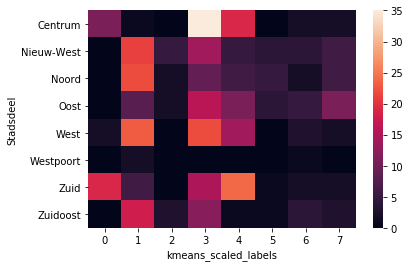

In [75]:
sns.heatmap(dfx2)

# it is clear from the heatmap that there is a non-equal count of the cluster across the stadsdelen, so there is some dependence

In [ ]:
chi2_contingency(dfx2)

# the p-value is very small (1.6140032016367972e-30), so there is a very significant relationship between the Stadsdelen and the kmeans clusters

## Conclusions:

- Energy score and number of solar panels not very good predictors of income
- K-nearest neighbors best accuracy score (0.33)
- Prediction of city district with energy score, solar panels and income not great either
- K-nearest neighbors and logistic regression performed comparably (accuracy score ~0.37)
- Unsupervised learning clusters show significant relationship with city districts

## Comments Paolo

Maaike, very good analysis, I loved how you tried different options and different algorithms. Also I liked the coupling you show at the end between burten and what kmeans found. I only have a couple of comments
- For the regressions you could try to add some plotting to show differences between predictions and test values
- When you try different parameters in the algorithms you could try the same approach Victor used. Essentially a loop with a series of possible values for the parameters that selects the best parameters for you instead of doing it manually. This way you can test many more values easily.